# Home Credit Defaulter Prediction

# 1. Introduction

## 1.1 About Data

* application_train/application_test: It is the main training and testing data with information about each loan application at Home Credit. Every loan is identified by the column SK_ID_CURR. Traing data set has the column Target which specifies if the loan was repaid or not. 0 indicated loan was repaid. 1 - not repaid (Bad debts) 

* bureau: data about the client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

<center>
<img src="Output_Images/ER_image.png" width=400 />
</center>

## 1.2 Import data packages

In [203]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import lightgbm as lgb #pip install lightgbm
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
import os
import matplotlib.pyplot as plt

In [204]:
#Reading the train data
appli_train = pd.read_csv('./Data/application_train.csv')
appli_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
#Reading the test data
appli_test = pd.read_csv('./Data/application_test.csv')
appli_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# 2 Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. EDA helps us to make inferences from the data so that we can decide the features to use for modelling data. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. 


The data set appli_train has 122 columns. So it is necessary to find out the highest correlated columns to make the best predictions


-> Finding the positvely and negatively correlated columns with the target so that we can select the piority columns and eliminate the least important columns    
-> Sorted the correlation values     
-> Eliminated the least important columns

In [206]:

corr = appli_train.corr()['TARGET'].sort_values()

In [207]:
# Positive Correlation Values
print('Positive Correlation Values:\n', corr.tail(15))
#Negative Correlation Values
print('Negative Correlation Values:\n', corr.head(15))

Positive Correlation Values:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
Negative Correlation Values:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645

-> From the above coorelation matrix the days of birth (or Age) has the highest positive coorelation with the target

-> So we are trying to find how target varies with age

In [208]:
# Cleaning and changing the negative values (abnormal data) in the DAYS_BIRTH column into positive values using abs()
appli_test["DAYS_BIRTH"] = abs(appli_test["DAYS_BIRTH"])
appli_train["DAYS_BIRTH"] = abs(appli_train["DAYS_BIRTH"])

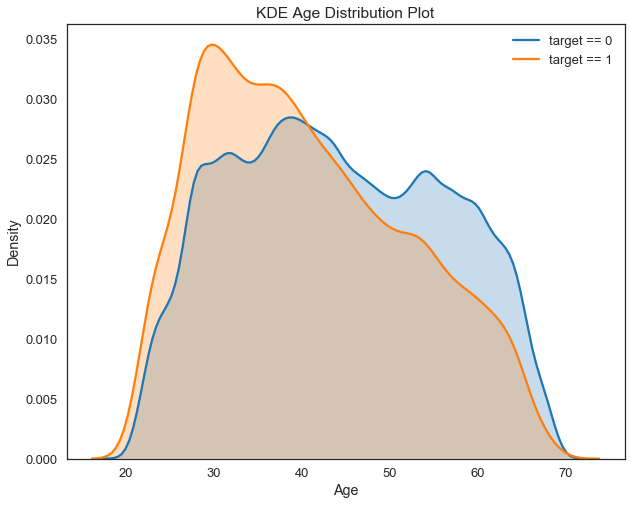

In [209]:
plt.figure(figsize = (10, 8))
# Kernel Density Estimation plot of loans that were repaid on time ( 0 indicates loan was repaid on time)
sns.distplot(appli_train.loc[appli_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0',hist = False,kde_kws = {'shade': True})
# Kernel Density Estimation plot of loans that were not repaid on time ( 1 indicates loan was not repaid on time)
sns.distplot(appli_train.loc[appli_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1', hist = False, kde_kws = {'shade': True})
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('KDE Age Distribution Plot')
plt.show()
#plt.savefig('KDE Age Distribution Plot.png')

-> From the above kernel Density Estimation we can infer that people in the age group 25- 35 are less likely to pay back the loan and people in the age group 35-50 number of people who failed to repay the loan is higher in the age group 35-50 are more likely to pay back

## 2.1 Correlation

-> Selecting the highest correlated columns with the Target column and plotting the heatmap 

In [210]:
# Extracting the columns with highest correlation with TARGET
ext_source_data = appli_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
#finding the correlation
ext_source_data_corr = ext_source_data.corr()
ext_source_data_corr

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Implementing Pearson correlation on the above columns and plotting the heat map

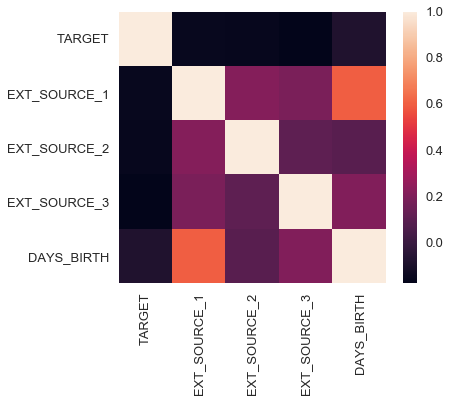

In [211]:
corrs = ext_source_data.corr(method="pearson")
plt.figure(figsize=(6,5))
sns.heatmap(corrs)
plt.show()

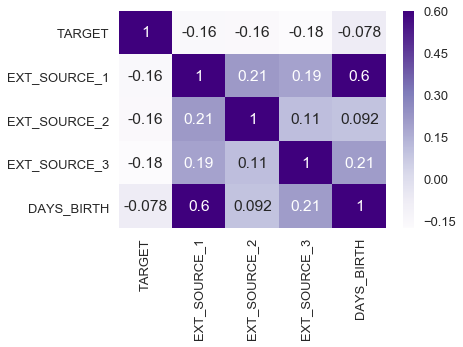

In [212]:
sns_plot = sns.heatmap(data=ext_source_data_corr, annot=True, vmax=0.6, cmap='Purples')
fig = sns_plot.get_figure()
fig.savefig('./Output_Images/Corr_heatmap.png')

Binning the age data into 4 age groups

In [213]:
age_group_data = appli_train[['TARGET', 'DAYS_BIRTH']]
age_group_data['YEARS_BIRTH'] = age_group_data['DAYS_BIRTH'] / 365
age_group_data['YEARS_BINNED'] = pd.cut(age_group_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11)) # Binning the age data
age_group_data.head(4)

C:\Users\soumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\soumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"


-> Plotting the correlation between the 4 columns selected. Dropping the null values and considering first 100000 rows for binned age data.

Diagonal elements in the plot are the KDE plots of the selected coulmn values and it shows how it varies with target

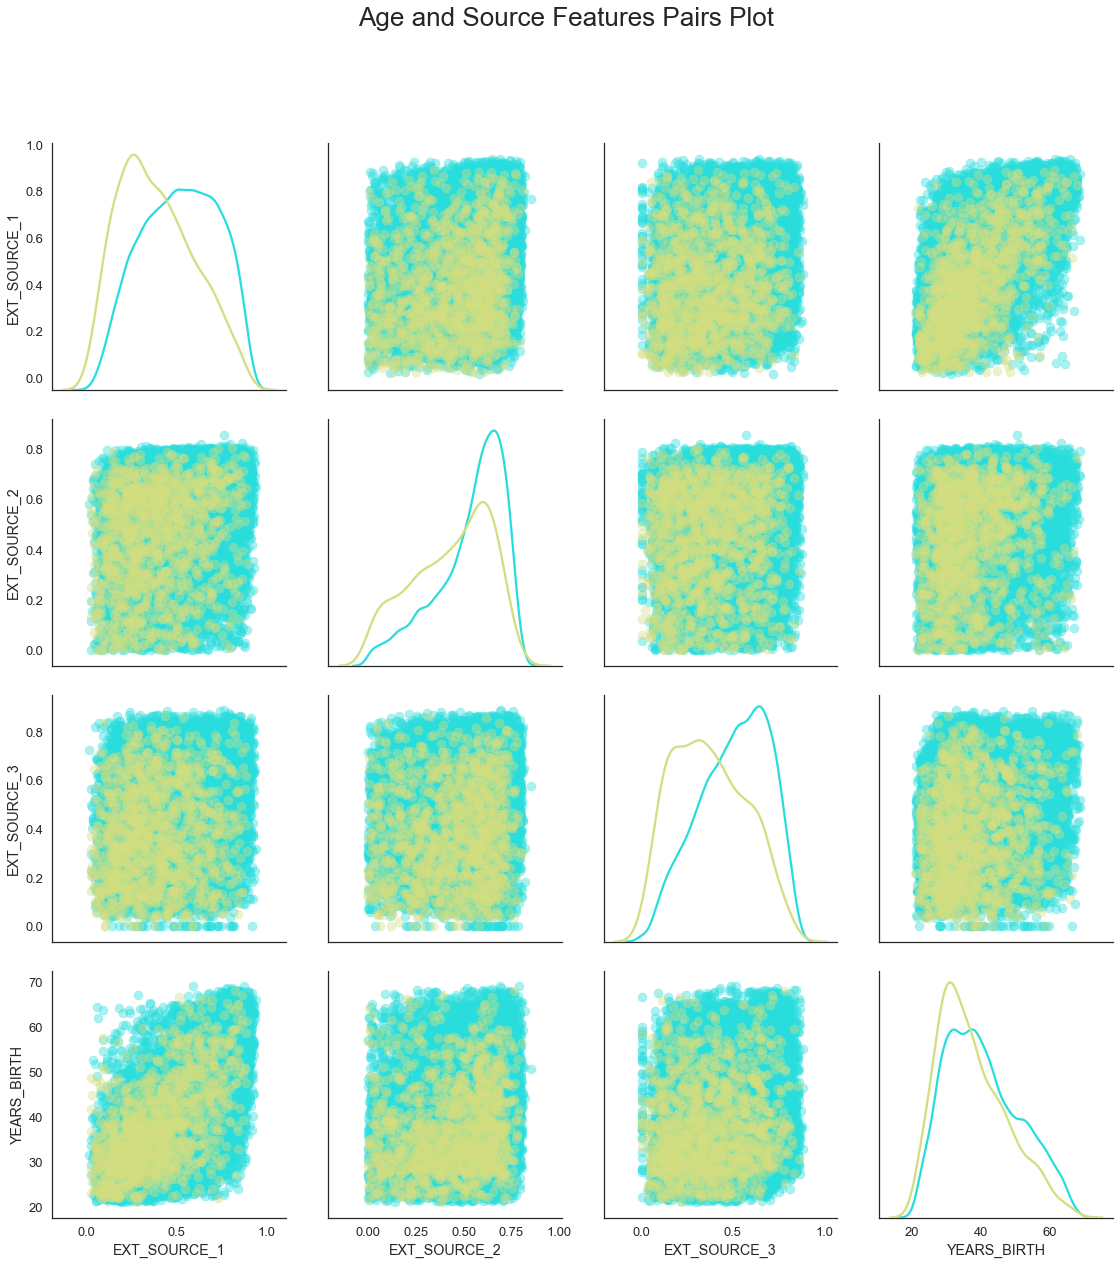

In [214]:
# Copy the data for plotting
sns_plot = ext_source_data.drop('DAYS_BIRTH', axis = 1).copy()
# Add in the age of the client in years
sns_plot['YEARS_BIRTH'] = age_group_data['YEARS_BIRTH']
# Dropping null values and limiting to first 100000 rows
sns_plot = sns_plot.dropna().loc[:50000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    re = np.corrcoef(x, y)[0][1]
    axe = plt.gca()
    axe.annotate("r = {:.2f}".format(re),xy=(.3, .9), xycoords=ax.transAxes,size = 24)

# Create the pairgrid object
grid = sns.PairGrid(palette= "rainbow",data = sns_plot, size = 4, diag_sharey=False,hue = 'TARGET', vars = [x for x in list(sns_plot.columns) if x != 'TARGET'])
# Diagonal kde plot
grid.map_diag(sns.kdeplot)
# Upper plot
grid.map_upper(plt.scatter, alpha = 0.4)
# Bottom plot
grid.map_lower(plt.scatter, alpha = 0.4)
plt.suptitle('Age and Source Features Pairs Plot', size = 26, y = 1.10);
plt.show()

In this plot yellow lines indicate loans that are not repaid and blue indicates the loans that are paid. We can observe a positive linear relationship between EXT_SOURCE_1 and YEARS_BIRTH indicating that these columns can be considered as important features for Target prediction

## 2.3 Distributions

Plotting the Kernal Desnity Estimation for the columns Amount Credit, Amount Annuity and Days Employed inorder to find the variation of Target with these values

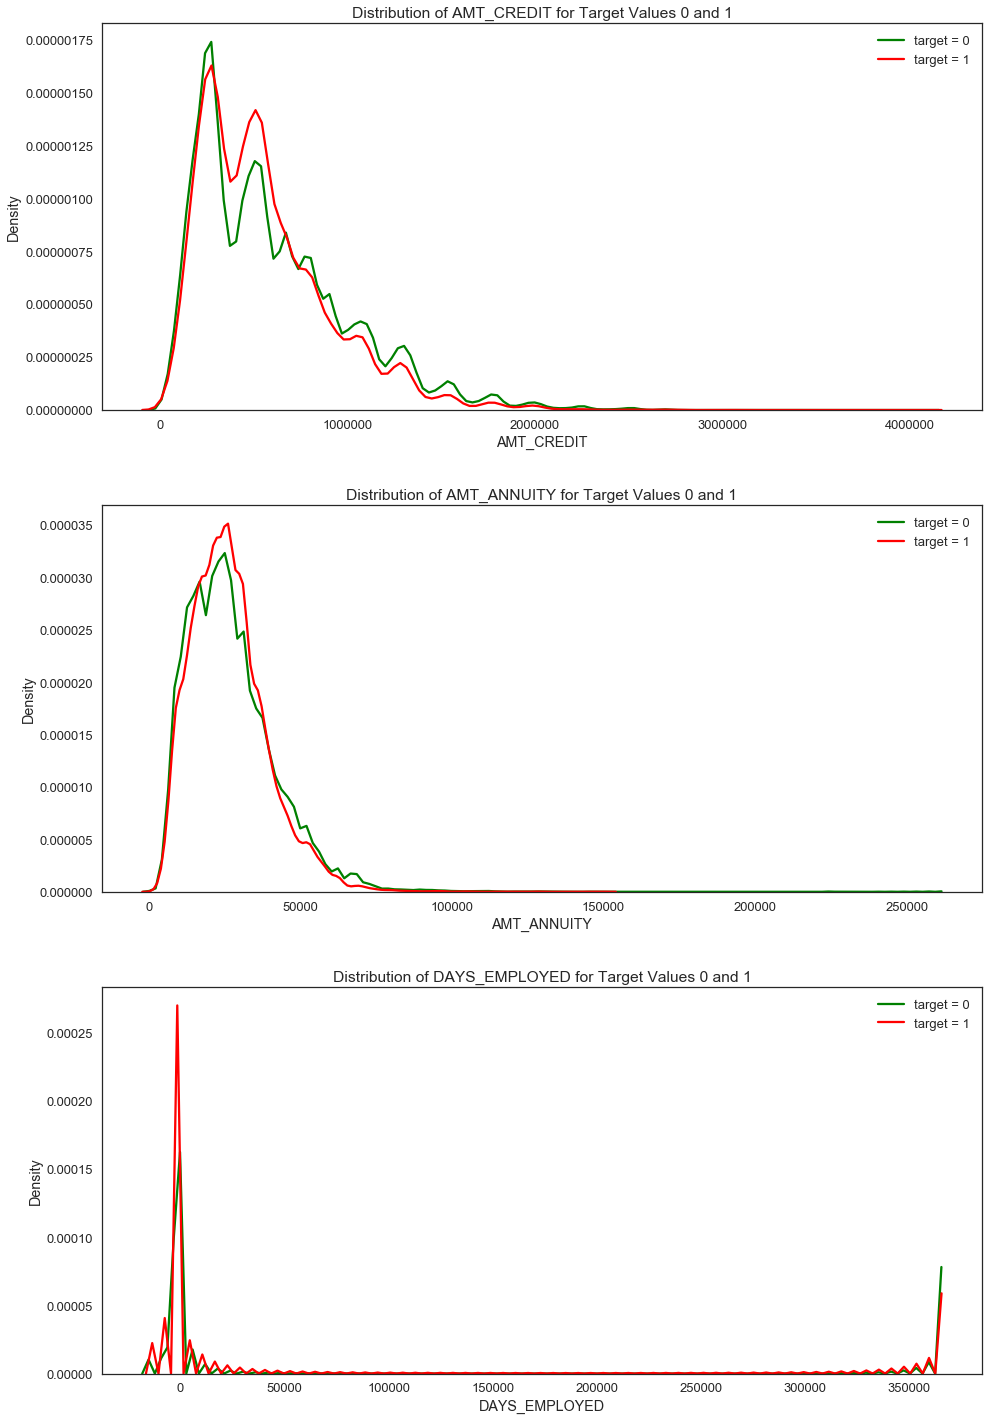

In [215]:
plt.figure(figsize = (14, 20))

# iterate through the below 3 features
for i, column in enumerate(['AMT_CREDIT', 'AMT_ANNUITY','DAYS_EMPLOYED']):
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # kde plots for loans that were repai
    sns.kdeplot(appli_train.loc[appli_train['TARGET'] == 0, column], label = 'target = 0',color="g")
    # kde plots loans that were not repaid
    sns.kdeplot(appli_train.loc[appli_train['TARGET'] == 1, column], label = 'target = 1',color='r')
    
    # Label the plots
    plt.title('Distribution of %s for Target Values 0 and 1' %column)
    plt.xlabel('%s' % column); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

From the  above plots, we can infer that there is no significant variation in the Density of these columns with the target values.
Hence these columns cannot be considered for Target prediction

Plotting the Percentage of defaulters by grouping them according to Occupation type, Organization type, education adn Housing type

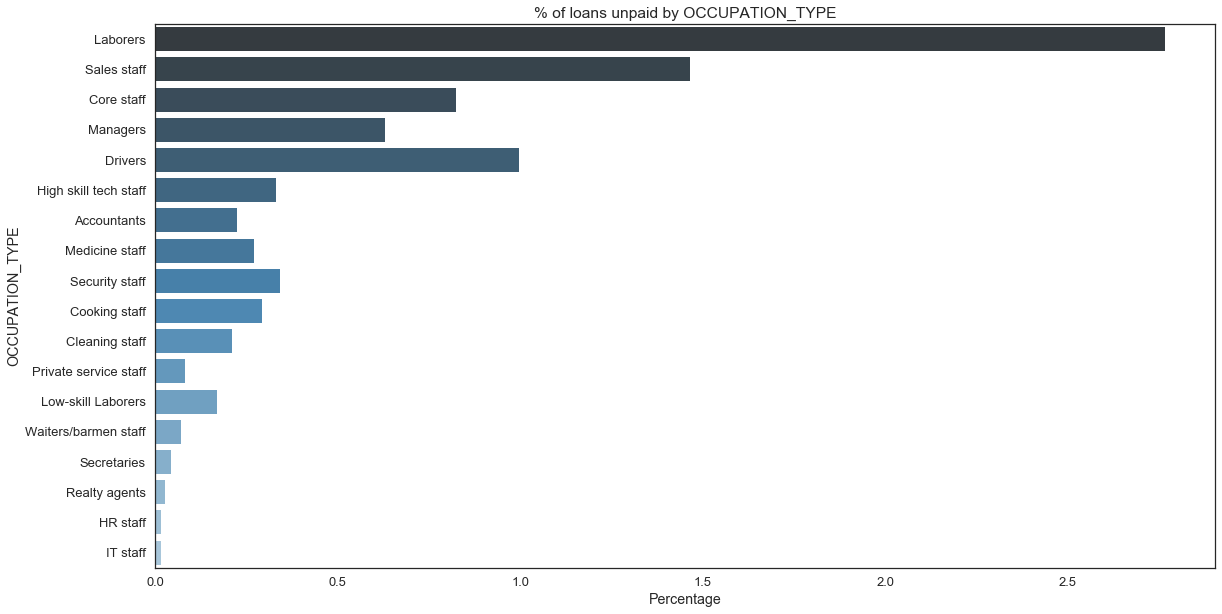

In [216]:
temp = appli_train["OCCUPATION_TYPE"].value_counts()
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(appli_train["TARGET"][appli_train["OCCUPATION_TYPE"]==val] == 1))
plt.figure(figsize=(19,10))
sns_plot = sns.barplot(((temp_y1/temp.sum())*100),temp.index,palette="Blues_d")
sns_plot.set_title("% of loans unpaid by OCCUPATION_TYPE")
sns_plot.set_xlabel("Percentage")
sns_plot.set_ylabel("OCCUPATION_TYPE")
fig = sns_plot.get_figure()
fig.savefig('./Output_Images/% of loans unpaid by OCCUPATION_TYPE.png')

Laborers are by far the biggest users of loans, and also have the greatest variance in incomes. It can also be observed that laborers have the highest percentage of loan defaulters , followed by Sales staff and core staff

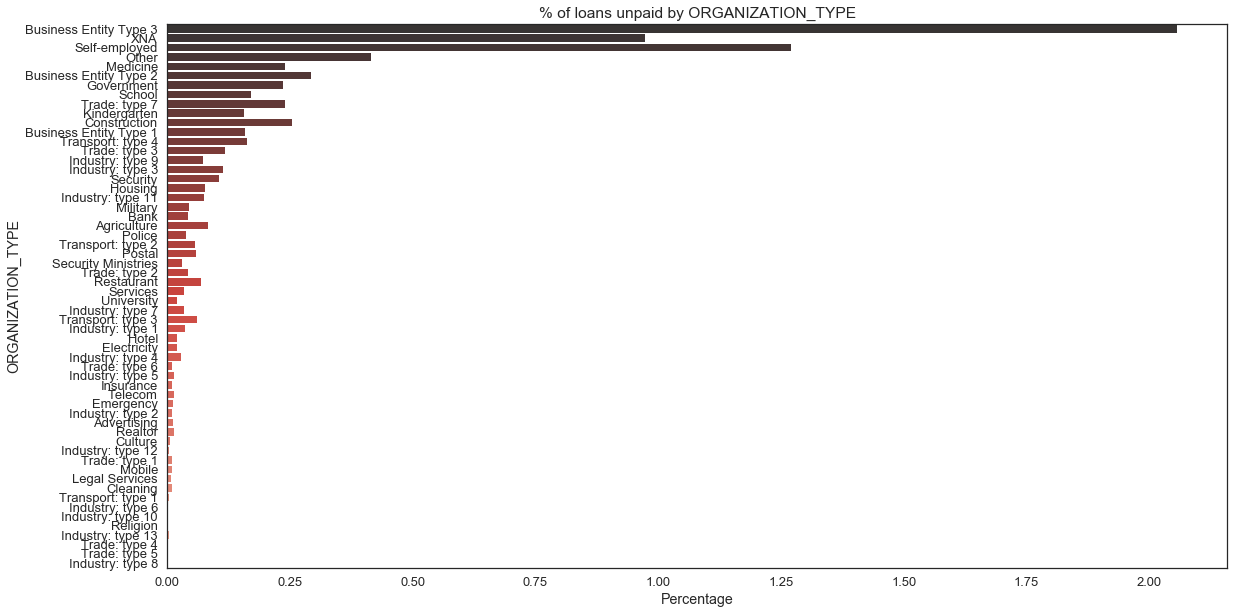

In [217]:
temp = appli_train["ORGANIZATION_TYPE"].value_counts()
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(appli_train["TARGET"][appli_train["ORGANIZATION_TYPE"]==val] == 1))
plt.figure(figsize=(19,10))
sns_plot = sns.barplot(((temp_y1/temp.sum())*100),temp.index,palette="Reds_d")
sns_plot.set_title("% of loans unpaid by ORGANIZATION_TYPE")
sns_plot.set_xlabel("Percentage")
sns_plot.set_ylabel("ORGANIZATION_TYPE")
fig = sns_plot.get_figure()
fig.savefig('./Output_Images/% of loans unpaid by ORGANIZATION_TYPE.png')

Analysing the plot for the percentage of loan defaulters grouped according to the organization type, people belonging to category Business Entity type3 and self employed have the highest percentage of loan defaulters

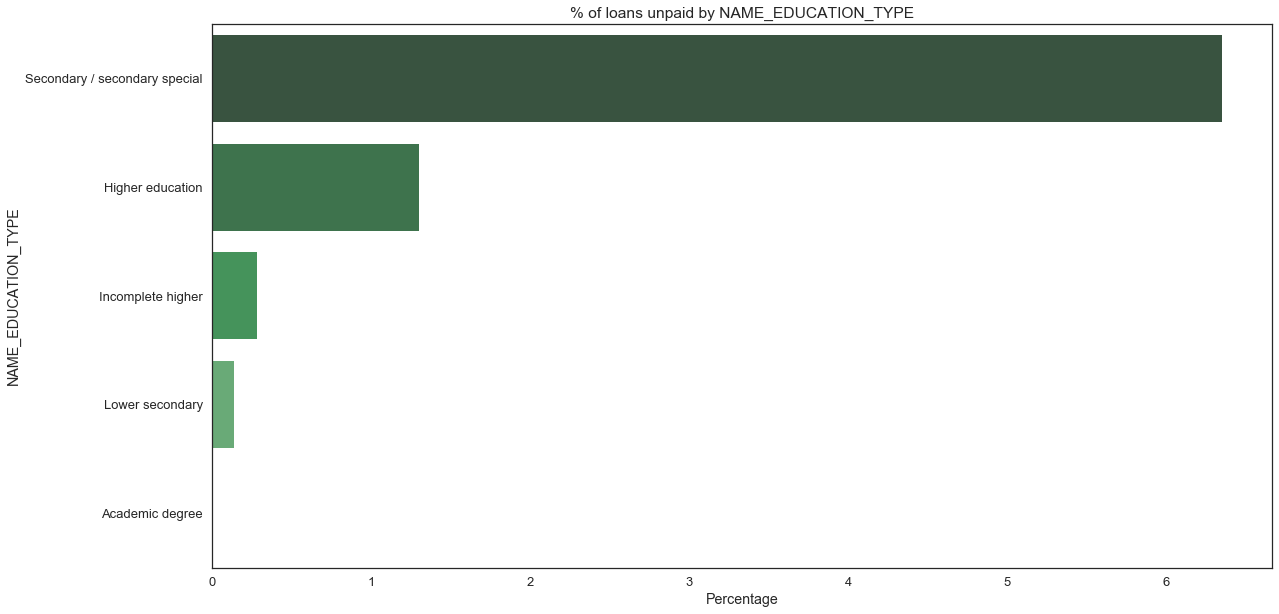

In [218]:
temp = appli_train["NAME_EDUCATION_TYPE"].value_counts()
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(appli_train["TARGET"][appli_train["NAME_EDUCATION_TYPE"]==val] == 1))
plt.figure(figsize=(19,10))
sns_plot = sns.barplot(((temp_y1/temp.sum())*100),temp.index,palette="Greens_d")
sns_plot.set_title("% of loans unpaid by NAME_EDUCATION_TYPE")
sns_plot.set_xlabel("Percentage")
sns_plot.set_ylabel("NAME_EDUCATION_TYPE")
fig = sns_plot.get_figure()
fig.savefig('./Output_Images/% of loans unpaid by NAME_EDUCATION_TYPE.png')

People with education type Secondary/secondary special are highly unlikely to repay the loan

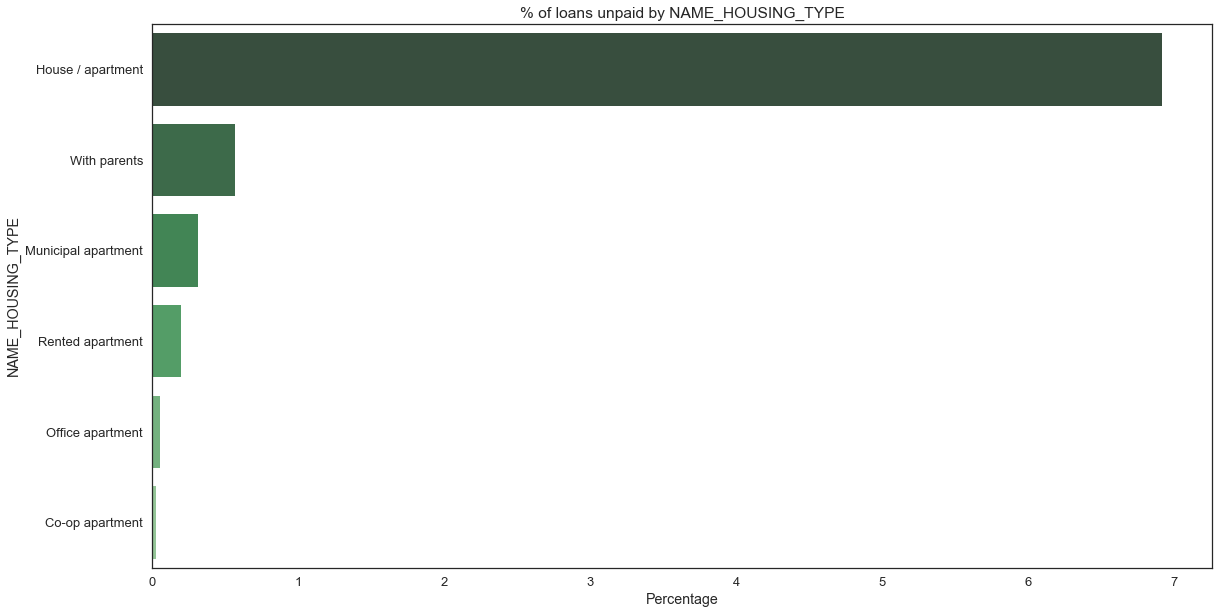

In [219]:
temp = appli_train["NAME_HOUSING_TYPE"].value_counts()
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(appli_train["TARGET"][appli_train["NAME_HOUSING_TYPE"]==val] == 1))
plt.figure(figsize=(19,10))
sns_plot = sns.barplot(((temp_y1/temp.sum())*100),temp.index,palette="Greens_d")
sns_plot.set_title("% of loans unpaid by NAME_HOUSING_TYPE")
sns_plot.set_xlabel("Percentage")
sns_plot.set_ylabel("NAME_HOUSING_TYPE")
fig = sns_plot.get_figure()
fig.savefig('./Output_Images/% of loans unpaid by NAME_HOUSING_TYPE.png')

# 3.Missing Data Observations

There are lots of NaN values in the dataset .This should be handled inorder to extract features for predicting the Target. We can fill the missing values with mean or mode, or eliminate the columns that havevery high percentage ofmissing values

In [220]:
#Missing Values in train
missing_val = appli_train.isnull().sum().sort_values(ascending=False)
print("Missing Values in Train Data\n",missing_val.head(10))

Missing Values in Train Data
 COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_AVG     213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_MODE       210199
LIVINGAPARTMENTS_AVG        210199
dtype: int64


In [221]:
# Missing value percentage
missing_val_percent = (missing_val * 100) / len(appli_train)
# Table with missing values and respective percentages
missing_val_table = pd.concat([missing_val, missing_val_percent], axis=1)
missing_val_table.head(10)

,0,1
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [222]:
# Rename the columns
missing_val_table_ren_columns = missing_val_table.rename(columns = {0 : 'Missing Values Count', 1 : 'Missing Values Percentage'})
# Sort the table by percentage of missing descending
missing_val_table_ren_columns = missing_val_table_ren_columns[missing_val_table_ren_columns.iloc[:,1] != 0].sort_values('Missing Values Percentage', ascending=False).round(1)
print(" mis_val_table_ren_columns\n", missing_val_table_ren_columns.head(20))
print ("Out of " + str(appli_train.shape[1]) + " columns.\n" + str(missing_val_table_ren_columns.shape[0]) + " columns have missing values.")

 mis_val_table_ren_columns
                           Missing Values Count  Missing Values Percentage
COMMONAREA_MEDI                         214865                       69.9
COMMONAREA_MODE                         214865                       69.9
COMMONAREA_AVG                          214865                       69.9
NONLIVINGAPARTMENTS_MODE                213514                       69.4
NONLIVINGAPARTMENTS_MEDI                213514                       69.4
NONLIVINGAPARTMENTS_AVG                 213514                       69.4
FONDKAPREMONT_MODE                      210295                       68.4
LIVINGAPARTMENTS_MEDI                   210199                       68.4
LIVINGAPARTMENTS_MODE                   210199                       68.4
LIVINGAPARTMENTS_AVG                    210199                       68.4
FLOORSMIN_MEDI                          208642                       67.8
FLOORSMIN_MODE                          208642                       67.8
FLOORSMIN_

In [223]:
# Missing values statistics
missing_values_perc= missing_val_table_ren_columns["Missing Values Percentage"]
df = missing_values_perc

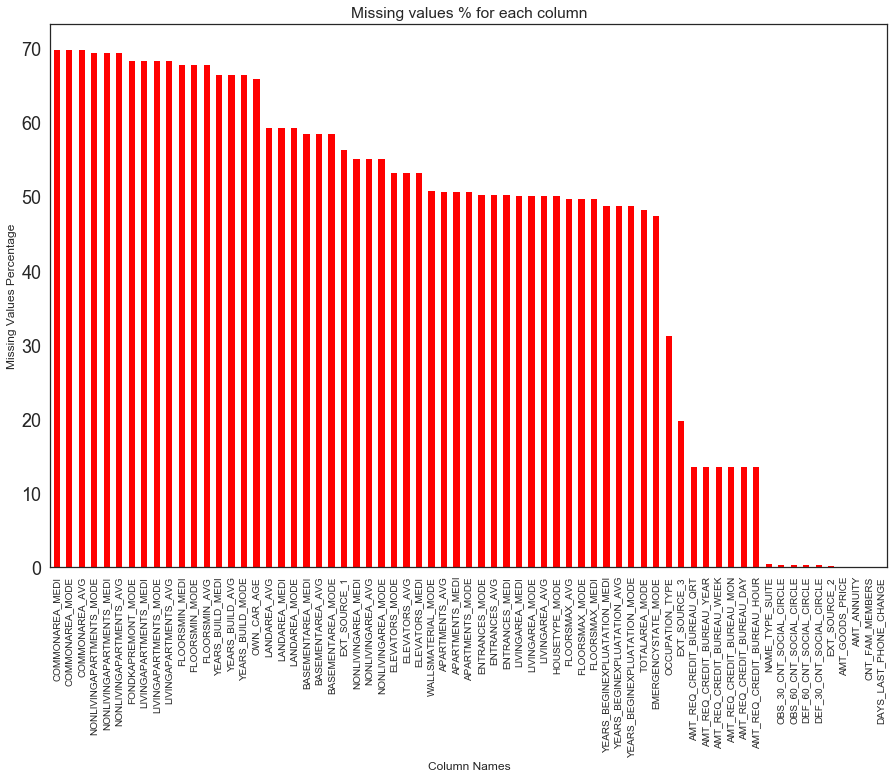

In [224]:
import matplotlib.pyplot as plt
sns_plot = df.plot(kind='bar', title ="Missing values % for each column",figsize=(15,10), fontsize=18,color="red")
sns_plot.set_xlabel("Column Names",fontsize=12)
sns_plot.set_ylabel("Missing Values Percentage",fontsize = 12)
plt.xticks(rotation = 90, fontsize = 10)
fig = sns_plot.get_figure()
fig.savefig('./Output_Images/Missing values % for each column.png')
plt.show()

The above figure clearly says about the missing values in each feature and precentage of missing value avaiable in application_train DataSet

# 4. Handling Missing Data

### Train Dataset
#### Missing values in Float and int columns are replaced by mean
#### Missing categorical variables are filled by mode

In [225]:
appli_clean_train=appli_train
flt_col = appli_clean_train.columns[appli_clean_train.dtypes==float]
appli_clean_train[flt_col] = appli_clean_train[flt_col].fillna(appli_clean_train[flt_col].mean())

In [226]:
obj_col = appli_clean_train.columns[appli_clean_train.dtypes==object]
appli_clean_train[obj_col] = appli_clean_train[obj_col].fillna(appli_clean_train[obj_col].mode())
appli_clean_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,1.000000,1.000000
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.000000,0.000,0.000000,1.000000,1.000000,2.000000
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974


In [227]:
appli_clean_train.to_csv('./output_files/application_train_clean.csv')

In [228]:
#Missing Values in train
missing_val = appli_clean_train.isnull().sum().sort_values(ascending=False)
print("Missing Values in Train Data\n",missing_val.head(10))
missing_val.to_csv("./output_files/Missing_values.csv")

Missing Values in Train Data
 FONDKAPREMONT_MODE         210295
WALLSMATERIAL_MODE         156341
HOUSETYPE_MODE             154297
EMERGENCYSTATE_MODE        145755
OCCUPATION_TYPE             96391
NAME_TYPE_SUITE              1292
LIVINGAPARTMENTS_AVG            0
ORGANIZATION_TYPE               0
NONLIVINGAPARTMENTS_AVG         0
LIVINGAREA_AVG                  0
dtype: int64


### Test Data

In [229]:
appli_clean_test=appli_test
flt_col = appli_clean_test.columns[appli_clean_test.dtypes==float]
appli_clean_test[flt_col] = appli_clean_test[flt_col].fillna(appli_clean_test[flt_col].mean())

In [230]:
obj_col = appli_clean_test.columns[appli_clean_test.dtypes==object]
appli_clean_test[obj_col] = appli_clean_test[obj_col].fillna(appli_clean_test[obj_col].mode())
appli_clean_test.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
5,100042,Cash loans,F,Y,Y,0,270000.0,959688.0,34600.5,810000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
6,100057,Cash loans,M,Y,Y,2,180000.0,499221.0,22117.5,373500.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
7,100065,Cash loans,M,N,Y,0,166500.0,180000.0,14220.0,180000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
8,100066,Cash loans,F,N,Y,0,315000.0,364896.0,28957.5,315000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
9,100067,Cash loans,F,Y,Y,1,162000.0,45000.0,5337.0,45000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000


In [231]:
appli_clean_test.to_csv('./output_files/application_test_clean.csv')

We are writing the cleaned data to a csv file which we will be using for modelling later

### MCMC and MLE

We are applying MCMC and MLE on the column Days_credit for the credits that are closed. 


We are combining the data sets appli_train and bureau using the column SK_ID_CURR to find the DAYS_CREDIT for every closed loan.

This merged data set is used to find the Most Likelihood estimate for the column Days_Credit
For applying MCMC and MLE we are considering loans where the borrowers are Laborers



In [232]:
bureau= pd.read_csv('./Data/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Selecting the columns from df where borrowers are Laborers

In [233]:
y=appli_clean_train[appli_clean_train['OCCUPATION_TYPE'] == 'Laborers']


Merged the above data frame with bureau to get the DAYS_CREDIT for every loan application. The Days_credit values in the data set are negative(abnormal data). So we found the absolute values and divided by 365 to find out the years taken for closing the loan

In [234]:
df=pd.merge(bureau, y, left_on="SK_ID_CURR", right_on="SK_ID_CURR").drop('SK_ID_CURR', axis=1)
df['DAYS_CREDIT']=abs(df['DAYS_CREDIT']/365)
df.head(10)

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,5714502,Active,currency 1,1.427397,0,551.0,NaN,NaN,0,112500.00,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,5714503,Closed,currency 1,1.531507,0,NaN,-355.0,0.0,0,110250.00,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,5714504,Closed,currency 1,6.610959,0,-1864.0,-2128.0,NaN,0,180000.00,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
3,5714506,Active,currency 1,2.578082,0,-17.0,NaN,NaN,0,40500.00,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
4,5714507,Closed,currency 1,3.041096,0,-745.0,-727.0,NaN,0,114727.50,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
5,5714508,Closed,currency 1,5.843836,0,-1038.0,-1127.0,NaN,0,225000.00,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
6,5714509,Active,currency 1,1.071233,0,705.0,NaN,NaN,0,142290.00,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7,5714505,Closed,currency 1,1.893151,0,-326.0,-326.0,NaN,0,160335.00,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
8,5714552,Closed,currency 1,3.898630,0,-1119.0,-1118.0,NaN,0,79744.50,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
9,5714553,Closed,currency 1,1.824658,0,-574.0,-574.0,0.0,0,36916.56,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


Selecting the rows that have credit state closed

In [235]:
df=df[df['CREDIT_ACTIVE']=='Closed']
df


,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
1,5714503,Closed,currency 1,1.531507,0,NaN,-355.0,0.00,0,110250.000,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,5714504,Closed,currency 1,6.610959,0,-1864.0,-2128.0,NaN,0,180000.000,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
4,5714507,Closed,currency 1,3.041096,0,-745.0,-727.0,NaN,0,114727.500,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
5,5714508,Closed,currency 1,5.843836,0,-1038.0,-1127.0,NaN,0,225000.000,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7,5714505,Closed,currency 1,1.893151,0,-326.0,-326.0,NaN,0,160335.000,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
8,5714552,Closed,currency 1,3.898630,0,-1119.0,-1118.0,NaN,0,79744.500,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
9,5714553,Closed,currency 1,1.824658,0,-574.0,-574.0,0.00,0,36916.560,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
11,5714555,Closed,currency 1,1.186301,0,-320.0,-320.0,0.00,0,67500.000,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
12,5714598,Closed,currency 1,2.693151,0,-623.0,-900.0,NaN,0,52987.500,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,3.0
13,5714600,Closed,currency 1,3.024658,0,-738.0,-731.0,NaN,0,194400.000,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,3.0


Code for MLE

In [236]:
amean = df['DAYS_CREDIT'].mean()
log_mean=np.log(amean)
log_mean
mlog= np.log(df['DAYS_CREDIT'])
mean_log=mlog.mean()

In [237]:

from scipy.special import psi, polygamma
from scipy.optimize import newton

dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [238]:
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean, mean_log))
alpha_mle


2.5848801485813566

In [239]:
beta_mle=alpha_mle/amean
beta_mle

0.67070665945243235

C:\Users\soumy\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


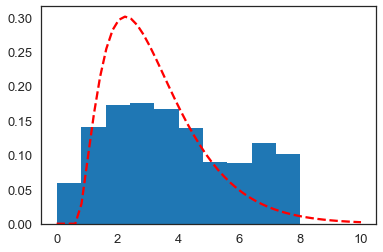

In [240]:
from scipy.stats.distributions import gamma
abs(df['DAYS_CREDIT']).hist(normed=True, bins=10, grid=False)
x = np.linspace(0, 10)
#plt.plot(x, gamma.pdf(x, alpha_mom[-1], beta_mom[-1]), 'b-')
plt.plot(x, gamma.pdf(x, alpha_mle,beta_mle), 'r--')

The estimated model fits the histogram of the data

In [241]:
from scipy.stats import gamma
gamma.fit(abs(df['DAYS_CREDIT']))

(4.8721940395490417, -1.0082447227221114, 0.99795062538822599)

mu


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
Metropolis: [mu]
100%|███████████████████████████████████████████████████████████████████████████| 15500/15500 [00:27<00:00, 570.43it/s]
The number of effective samples is smaller than 10% for some parameters.
C:\Users\soumy\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


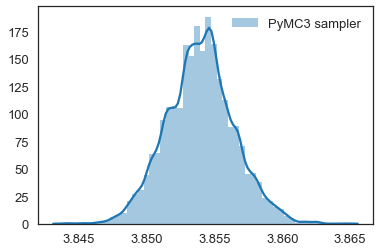

In [242]:
import pymc3 as pm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)
data = np.random.randn(20)

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    print(mu)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=abs(df['DAYS_CREDIT']))
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
plt.legend();

Above figure is the posterior distribution of the mean values of the number of years that will be taken by the borrowers to close the credit account

# 5. Modelling

## 5.1 Modelling - Feature engg on original data

In [243]:
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
import lightgbm as lgb

All the Categorical columns should be encoded before loading them to the classifiers

In [244]:
catego_featu = [x for x in appli_train.columns if appli_train[x].dtype == 'object']

for name in catego_featu:
    enc = preprocessing.LabelEncoder()
    enc.fit(list(appli_train[name].values.astype('str')) + list(appli_test[name].values.astype('str')))
    appli_test[name] = enc.transform(appli_test[name].values.astype('str'))
    appli_train[name] = enc.transform(appli_train[name].values.astype('str'))

Inorder ot find the best classifier, we are splitting the train data into test and train 

In [245]:
X_train = appli_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
Y_train = appli_train['TARGET']
X_train.fillna(-1000, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

#### Every classifier exposes a score which measures the quality of the fit (or the prediction) on the data. 
#### Bigger is better.

In [246]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_train)
knn_clfs = knn_clf.score(x_test, y_test) * 100
print("KNN Score = ", round(knn_clfs,4))

KNN Score =  91.345


A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [247]:
rand_clf = RandomForestClassifier()
rand_clf.fit(x_train, y_train)
rand_clfs = rand_clf.score(x_test, y_test) * 100
print("Random Forest Score = ", round(rand_clfs,4))

Random Forest Score =  91.8811


Naive Bayes classifier. In machine learning, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features

In [248]:
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
lr_clfs = lr_clf.score(x_test, y_test) * 100
print("Logistic Regr Score = ", round(lr_clfs,4))

Logistic Regr Score =  92.0003


In [249]:
# Initialize our classifier
gauss_clf = GaussianNB()
gauss_clf.fit(x_train, y_train)
gauss_clfs = gauss_clf.score(x_test, y_test) * 100
print("Gaussian Naive Bayes = ", round(gauss_clfs,4))

Gaussian Naive Bayes =  92.0013


Light GBM is a gradient boosting framework that uses tree based learning algorithm.

How it differs from other tree based algorithm? Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm

In [250]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(x_train, y_train) 
lgb_clfs = lgb_clf.score(x_test, y_test) * 100
print("LGBM Score = ", round(lgb_clfs,4))

LGBM Score =  92.0151


XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning

In [251]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)
xgb_clfs = xgb_clf.score(x_test, y_test) * 100
print("XGBoost Score = ", round(xgb_clfs,4))

XGBoost Score =  92.021


According to the Accuracy scores XGBoost has the highest score. So we are using XGBOOST classifier to model the test data set and predict Target values

In [252]:
# select features using threshold
mod_sel = SelectFromModel(xgb_clf, threshold=0.05, prefit=True)
select_X_train = mod_sel.transform(x_train)
select_mod = XGBClassifier()
select_mod.fit(select_X_train, y_train)
X_test = appli_test.fillna(-1000)
select_X_test = mod_sel.transform(X_test.drop(['SK_ID_CURR'], axis=1))
prediction = select_mod.predict(select_X_test)

In [253]:
prediction = select_mod.predict_proba(select_X_test)
prediction = pd.DataFrame(prediction)
submission = pd.DataFrame()
submission['SK_ID_CURR'] = appli_test['SK_ID_CURR']
submission['TARGET'] = prediction.iloc[:, 1]

Output of the predictor is the probabilty that a borrower will  pay back the loan

In [254]:
submission['TARGET'].head(20)

0     0.036350
1     0.092998
2     0.026303
3     0.043834
4     0.137845
5     0.069403
6     0.019614
7     0.069625
8     0.010401
9     0.196862
10    0.072918
11    0.052988
12    0.125486
13    0.139063
14    0.058300
15    0.088715
16    0.066473
17    0.031805
18    0.125592
19    0.022718
Name: TARGET, dtype: float32

Creating a dataframe containing Target values and SK_ID_CURR. The obtained probability values are compared with a threshold value 0.1686 to fill the Target column with 0 or 1.  

In [255]:
df = submission
df['TARGET']= np.where(df['TARGET']<=0.1686, 0, 1)
print(df.head(10))
df.to_csv('./output_files/predicted_target_originaldata.csv', index=False)

   SK_ID_CURR  TARGET
0      100001       0
1      100005       0
2      100013       0
3      100028       0
4      100038       0
5      100042       0
6      100057       0
7      100065       0
8      100066       0
9      100067       1


## Light GBM

Plotting the feature importance using LightGBM. Plotting only the top features

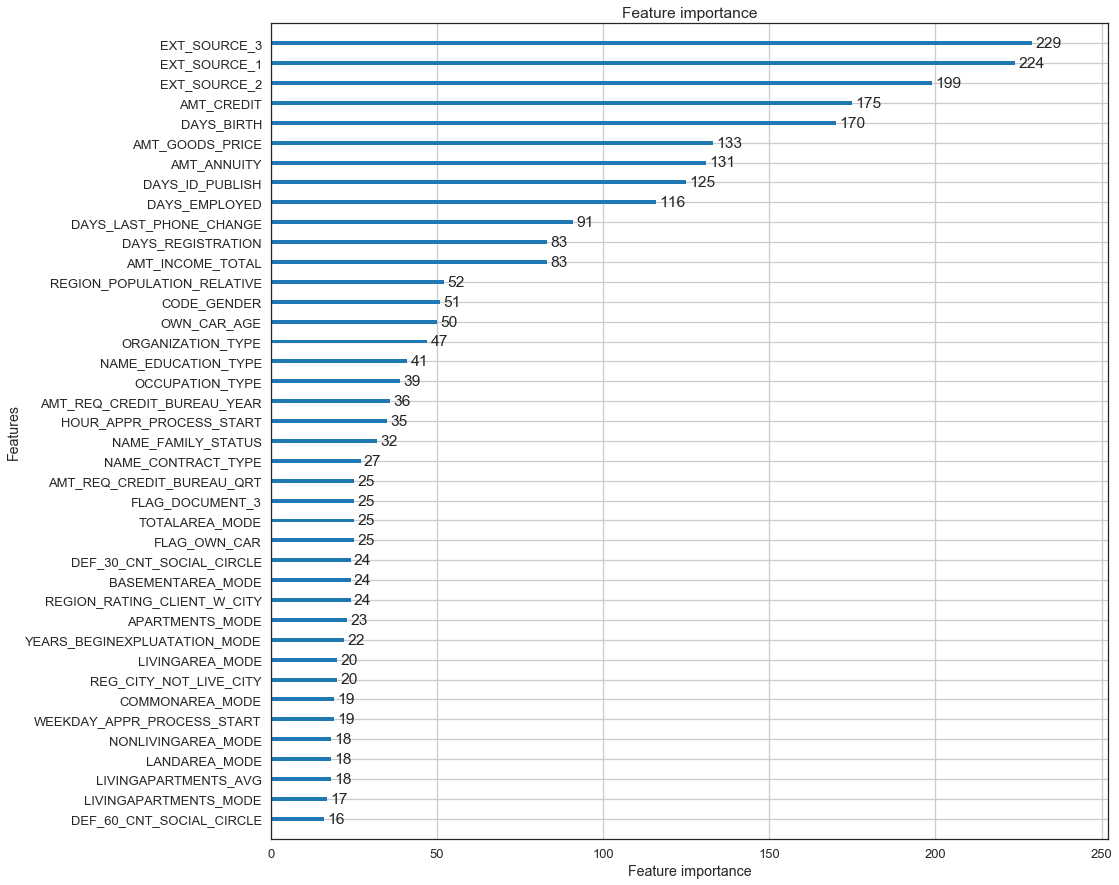

<Figure size 432x288 with 0 Axes>

In [256]:
ax = lgb.plot_importance(lgb_clf,figsize=(15,15),max_num_features=40)
plt.show()
plt.savefig("./Output_Images/Feature Importance_Lightgbm.png")

## XGBoost Classifier

Feature importance according to XGBoost

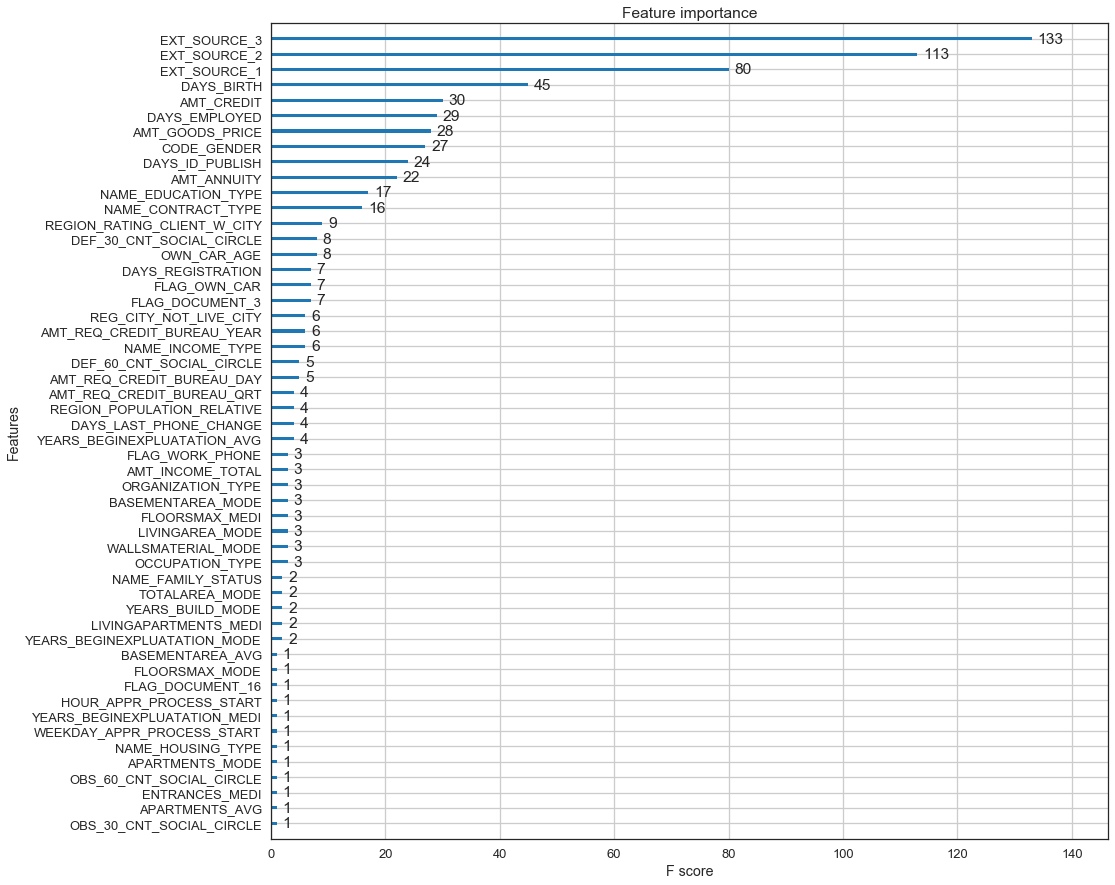

In [257]:
ax = plot_importance(xgb_clf)
fig = ax.figure
fig.set_size_inches(15, 15)
plt.show()
fig.savefig("./output_files/Feature Importance_XGBoost.png")

## 5.2 Modelling on cleaned data

The above steps are repeated for the cleaned data

In [259]:
X_train = appli_clean_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
Y_train = appli_clean_train['TARGET']
X_train.fillna(-1000, inplace=True) 
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [260]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_train)
knn_clfs = knn_clf.score(x_test, y_test) * 100
print("KNN Score = ", round(knn_clfs,4))

KNN Score =  91.3005


In [261]:
rand_clf = RandomForestClassifier()
rand_clf.fit(x_train, y_train)
rand_clfs = rand_clf.score(x_test, y_test) * 100
print("Random Forest Score = ", round(rand_clfs,4))

Random Forest Score =  91.8247


In [262]:
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
lr_clfs = lr_clf.score(x_test, y_test) * 100
print("Logistic Regr Score = ", round(lr_clfs,4))

Logistic Regr Score =  91.9457


In [263]:
# Initialize our classifier
gauss_clf = GaussianNB()
gauss_clf.fit(x_train, y_train)
gauss_clfs = gauss_clf.score(x_test, y_test) * 100
print("Gaussian Naive Bayes = ", round(gauss_clfs,4))

Gaussian Naive Bayes =  91.947


In [264]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(x_train, y_train) 
lgb_clfs = lgb_clf.score(x_test, y_test) * 100
print("LGBM Score = ", round(lgb_clfs,4))

LGBM Score =  91.9769


In [265]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)
xgb_clfs = xgb_clf.score(x_test, y_test) * 100
print("XGBoost Score = ", round(xgb_clfs,4))

XGBoost Score =  91.9587


In [266]:
# select features using threshold
mod_sel = SelectFromModel(xgb_clf, threshold=0.05, prefit=True)
select_X_train = mod_sel.transform(x_train)
select_mod = XGBClassifier()
select_mod.fit(select_X_train, y_train)
X_test = appli_test.fillna(-1000)
select_X_test = mod_sel.transform(X_test.drop(['SK_ID_CURR'], axis=1))
prediction = select_mod.predict(select_X_test)

In [267]:
prediction = select_mod.predict_proba(select_X_test)
prediction = pd.DataFrame(prediction)
submission = pd.DataFrame()
submission['SK_ID_CURR'] = appli_test['SK_ID_CURR']
submission['TARGET'] = prediction.iloc[:, 1]

In [268]:
df = submission
df['TARGET']= np.where(df['TARGET']<=0.1686, 0, 1)
print(df.head(10))
df.to_csv('./output_files/clean_predicted_target.csv', index=False)

   SK_ID_CURR  TARGET
0      100001       0
1      100005       0
2      100013       0
3      100028       0
4      100038       0
5      100042       0
6      100057       0
7      100065       0
8      100066       0
9      100067       1


### Examining the test data. 

Plotting the ratio of entries with Target 1 and 0

In [269]:
df["TARGET"].value_counts()

0    44791
1     3953
Name: TARGET, dtype: int64

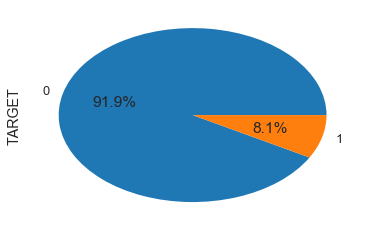

In [270]:
df["TARGET"].value_counts().plot.pie(autopct ="%1.1f%%")
plt.savefig("./output_files/ratio_target.png")

This ratio is similar to the training data set.

In [278]:
appli_test = pd.read_csv('./Data/application_test.csv')
appli_train= pd.read_csv('./Data/application_train.csv')


In [279]:
predi_stat=pd.merge(df,appli_test,left_on='SK_ID_CURR',right_on='SK_ID_CURR').drop('SK_ID_CURR', axis =1)
predi_stat.head(10)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,0,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,0,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,0,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,0,Cash loans,F,Y,Y,0,270000.0,959688.0,34600.5,810000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
6,0,Cash loans,M,Y,Y,2,180000.0,499221.0,22117.5,373500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,0,Cash loans,M,N,Y,0,166500.0,180000.0,14220.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
8,0,Cash loans,F,N,Y,0,315000.0,364896.0,28957.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
9,1,Cash loans,F,Y,Y,1,162000.0,45000.0,5337.0,45000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [285]:
def plot_test(df1,df2,t1,t2):
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    sns.countplot(t1,hue=t2,data=df1,palette="gist_rainbow_r")
    plt.title("Train - Repayer vs Defualter")
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0.6,wspace=0.8)
    plt.subplot(1,2,2)
    sns.countplot(t1,hue=t2,data=df2,palette="gist_rainbow_r")
    plt.title("Test- Repayer vs Defualter")
  # Rotate x-labels
    #plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.xticks(rotation=90)
    a=plt.show()
    plt.subplots_adjust(hspace=0.6,wspace=0.8)
    fig.savefig("./output_files/occupation_type_comparison.png")
    
    return a

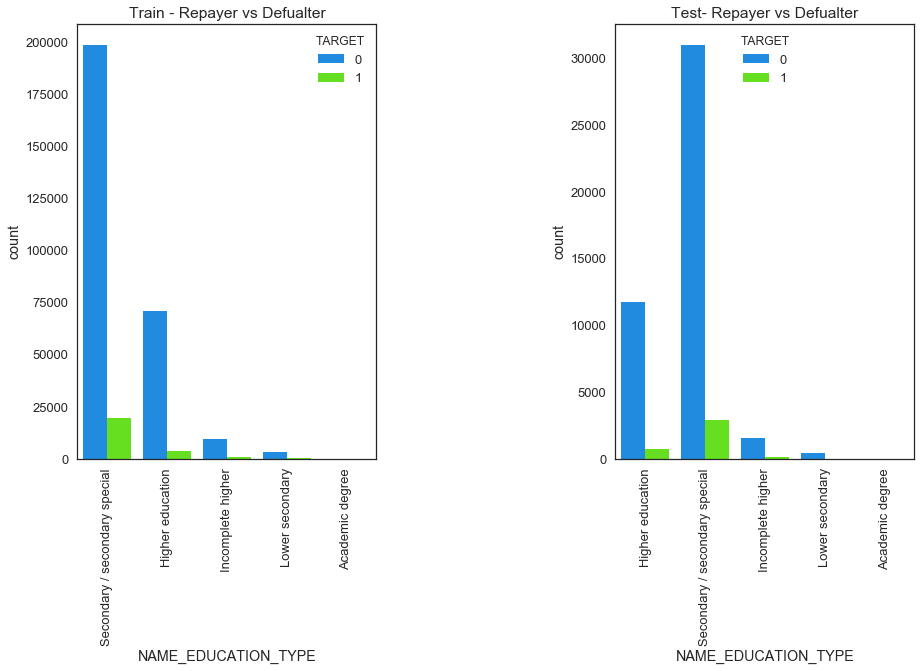

<Figure size 432x288 with 0 Axes>

In [281]:
plot_test(appli_train,predi_stat,'NAME_EDUCATION_TYPE','TARGET')

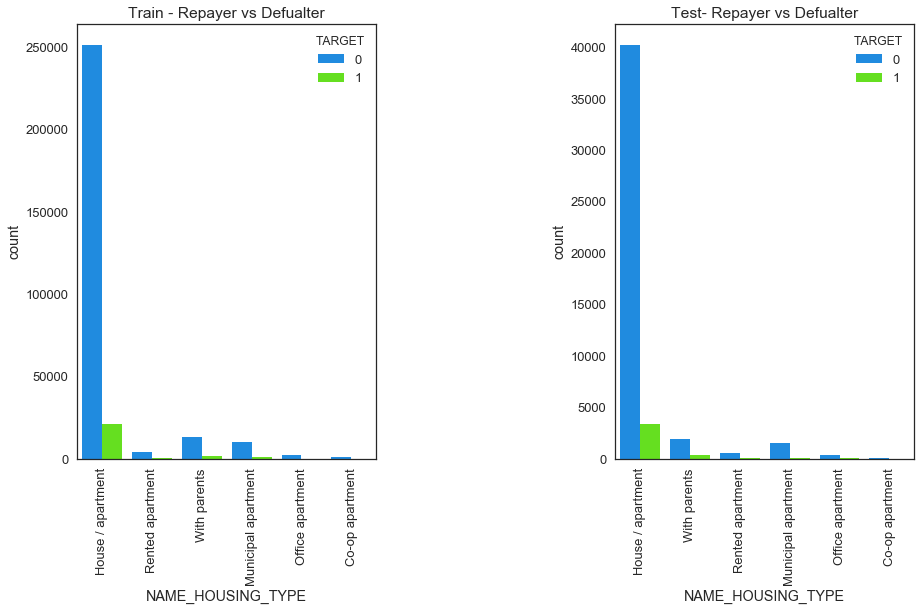

<Figure size 432x288 with 0 Axes>

In [284]:
plot_test(appli_train,predi_stat,'NAME_HOUSING_TYPE','TARGET')

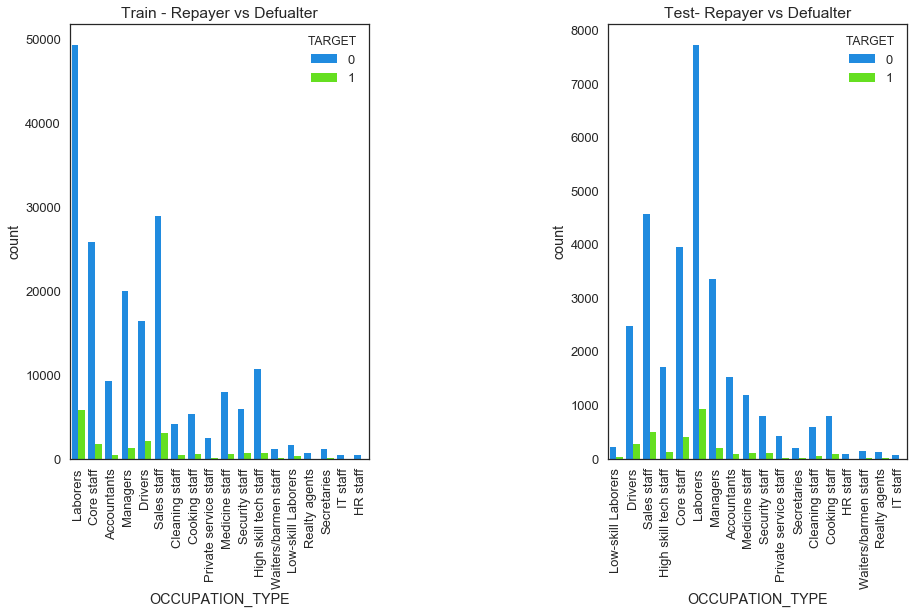

<Figure size 432x288 with 0 Axes>

In [286]:
plot_test(appli_train,predi_stat,'OCCUPATION_TYPE','TARGET')

Laborers have the highest number of defaulters in both test and training data sets

From the above plots we can see that the Target values predicted in the test data produce similar plots to the training data set for each feature. Hence the predictor model is reliable